In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
from pyspark.sql import functions as F
from manga_recsys.spark import get_spark

spark = get_spark()
spark

In [5]:
df = spark.read.parquet("../data/processed/2022-12-10-mangadex-manga/")
df.show(n=3, truncate=80)
df.printSchema()

+------------------------------------+--------------------------------------------------------------------------------+-----+--------------------------------------------------------------------------------+
|                                  id|                                                                   relationships| type|                                                                      attributes|
+------------------------------------+--------------------------------------------------------------------------------+-----+--------------------------------------------------------------------------------+
|6b64bfb7-8fff-4633-82e2-340cbb8bc92e|[{060503b8-a561-4dd8-8607-6524eebb90bf, null, author}, {060503b8-a561-4dd8-86...|manga|{[en], false, safe, 2021-03-12T22:52:05+00:00, false, null, null, 8b366aa0-41...|
|4660003f-15c9-4b52-84c1-ba46c6943edf|[{a49063fb-6a3e-4a4b-a304-dc1a1198afba, null, author}, {2a1c83c6-4bfd-41bf-8e...|manga|{[en], false, safe, 2018-10-04T19:06:02+00:00, 

# how many tags are there

In [12]:
tags = df.select("id", F.explode("attributes.tags").alias("tags")).select(
    "id", "tags.*"
)
tags.show(n=3, truncate=80)
tags.printSchema()

+------------------------------------+-------------------------+------------------------------------+-------------+----+
|                                  id|               attributes|                                  id|relationships|type|
+------------------------------------+-------------------------+------------------------------------+-------------+----+
|6b64bfb7-8fff-4633-82e2-340cbb8bc92e| {genre, {Boys' Love}, 1}|5920b825-4181-4a17-beeb-9918b0ff7a30|           []| tag|
|6b64bfb7-8fff-4633-82e2-340cbb8bc92e| {format, {Doujinshi}, 1}|b13b2a48-c720-44a9-9c77-39c9979373fb|           []| tag|
|6b64bfb7-8fff-4633-82e2-340cbb8bc92e|{format, {Full Color}, 1}|f5ba408b-0e7a-484d-8d49-4e9125ac96de|           []| tag|
+------------------------------------+-------------------------+------------------------------------+-------------+----+
only showing top 3 rows

root
 |-- id: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- group: string (nullable = true)
 |   

In [19]:
tags.groupBy("attributes.group").count().show()

+-------+------+
|  group| count|
+-------+------+
|  genre|162147|
| format| 65332|
|content|  3886|
|  theme| 60276|
+-------+------+



In [21]:
tags.groupBy("attributes.name.en").count().show()

+-------------+-----+
|           en|count|
+-------------+-----+
|    Anthology| 1664|
|  Girls' Love| 4989|
|     Monsters| 2262|
|       Horror| 2802|
|      Romance|25827|
|       Comedy|22401|
|       Ghosts|  755|
|        Harem| 2389|
|     Thriller| 1892|
|Magical Girls|  308|
|        Mecha|  810|
|    Adventure| 7232|
|     Military| 1361|
|      Samurai|  343|
|   Full Color| 9369|
|       Isekai| 2112|
|        Shota| 1203|
|        Mafia|  586|
|   Genderswap|  933|
|        Gyaru|  362|
+-------------+-----+
only showing top 20 rows



In [27]:
tags.where("size(relationships) > 0").show()

+---+----------+---+-------------+----+
| id|attributes| id|relationships|type|
+---+----------+---+-------------+----+
+---+----------+---+-------------+----+



## distribution of chapter counts

In [39]:
manga = df.select("id", "attributes.*").where("latestUploadedChapter is not null")

manga.show(n=3, truncate=80, vertical=True)

-RECORD 0----------------------------------------------------------------------------------------------------------
 id                             | 6b64bfb7-8fff-4633-82e2-340cbb8bc92e                                             
 availableTranslatedLanguages   | [en]                                                                             
 chapterNumbersResetOnNewVolume | false                                                                            
 contentRating                  | safe                                                                             
 createdAt                      | 2021-03-12T22:52:05+00:00                                                        
 isLocked                       | false                                                                            
 lastChapter                    | null                                                                             
 lastVolume                     | null                                  

In [47]:
pdf = manga.select(F.col("lastChapter").cast("double")).toPandas()

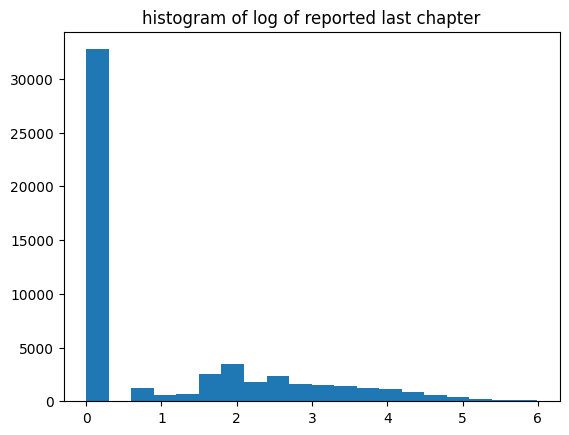

In [81]:
import matplotlib.pyplot as plt
import numpy as np

y = pdf.lastChapter[(pdf.lastChapter < 400)]
y[~(y > 0)] = 0
plt.hist(np.log(y + 1), bins=20)
plt.title("histogram of log of reported last chapter")
plt.show()